In [1]:
# 그래프, 수학 기능 추가
# Add graph and math features
import pylab as py
import numpy as np
import numpy.linalg as nl
# 기호 연산 기능 추가
# Add symbolic operation capability
import sympy as sy

In [2]:
sy.init_printing()

# 상미분방정식을 위한 전진 오일러법<br>Forward Euler Method for Ordinary Differntial Equation

## 여러 $(t, x)$ 지점에서의 기울기<br>Slopes at $(t, x)$ points

다시 한번 주어진 미분 방정식을 생각해 보자.<br>Let's think about the first order differential equation again.

$$
\left\{
    \begin{align}
        a_0 \frac{d}{dt}x(t)+a_1 x(t)&=0 \\
        x(0)&=x_0 \\
    \end{align}
\right.
$$

미분항을 남기고 나머지를 등호의 오른쪽으로 옮겨 보자.<br>Let's move terms except the differential to the right side of the equal sign.

$$
a_0 \frac{d}{dt}x(t)=-a_1 x(t)
$$

양변을 $a_0$로 나누어 보자.<br>Let's divide both sides with $a_0$.

$$
\frac{d}{dt}x(t)=-\frac{a_1}{a_0} x(t)
$$

이 식의 의미를 한번 생각해 보자.<br>Let's think about the meaning of this equation.

위 미분방정식을 만족시키는 어떤 함수 $x(t)$의 $t=t_i$, $x=x_j$ 점에서의 $t$에 대한 기울기는 다음과 같을 것이라는 의미이다.<br>
This equation indicates that a function $x(t)$ satisfying the differential equation above would have a slope as follows at a point of $t=t_i$ and $x=x_j$.

$$
\left.\frac{d}{dt}x\right|_{\left(t, x\right)=\left(t_i,x_j\right)}=-\frac{a_1}{a_0} x_j
$$

이런식으로 $t$의 변화에 따른 $x$의 기울기 $\frac{d}{dx}x(t)$ 를 모든 $(t, x)$ 점에서 구할 수 있다.<br>
In this way, we can find all the $\frac{d}{dx}x(t)$, slopes of $x$ with respect to the change of $t$ at all $(t, x)$ points.

## 기울기 시각화<br>Visualizing the slopes

다음 예를 생각해 보자.<br>
Let's think about an example as follows.

In [3]:
a_0, a_1 = 2.0, 1.0

$$
\left\{
    \begin{align}
        2 \frac{d}{dt}x(t)+ x(t)&=0 \\
        x(0)&=x_0 \\
    \end{align}
\right.
$$

기울기를 계산하는 파이썬 함수를 생각해 보자.<br>Let's think about a python function calculating the slope.

In [4]:
def dx_dt(x, t):
    return - a_1 * x / a_0

예를 들어 $0 \le t \le 10$, $-6 \le x \le 6$ 인 영역에서 기울기를 그려 보자.<br>
Let's plot slopes within the region of $0 \le t \le 10$ and $-6 \le x \le 6$.

In [5]:
t_array = py.linspace(0, 10)
x_array = py.linspace(-6, 6)

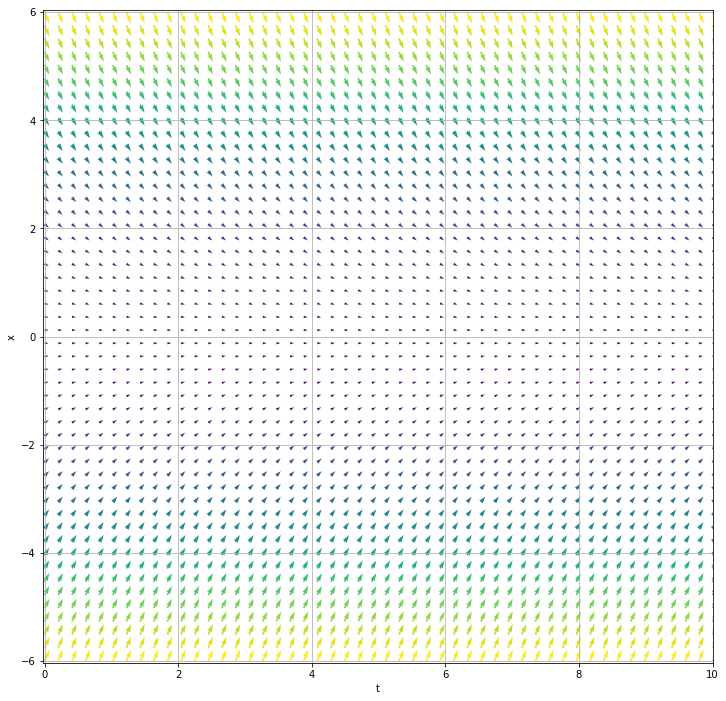

In [6]:
def ode_slope_1state_interval(func, delta_t, delta_x, te, ti, x_max, x_min):
    time_list = np.arange(ti, te, delta_t)
    x_list = np.arange(x_min, x_max + 0.5 * delta_x, delta_x)
    ode_slope_1state(func, x_list, time_list)
    return time_list


def ode_slope_1state(func, x_list, time_list):
    """
    Plot field of arrows indicating derivatives of the state
    :param func:
    :param x_list:
    :param time_list:
    :return:
    """
    time_mesh, x_mesh = np.meshgrid(time_list, x_list)
    u_mesh = np.ones_like(x_mesh)
    v_mesh = func(x_mesh, time_mesh)
    # magnitude as color
    color_mesh = np.sqrt(u_mesh * u_mesh + v_mesh * v_mesh)

    # https://stackoverflow.com/questions/29589119/plot-width-settings-in-ipython-notebook
    py.figure(figsize=(12, 12))
    py.quiver(time_mesh, x_mesh, u_mesh, v_mesh, color_mesh, angles='xy')
    py.xlabel('t')
    py.ylabel('x')
    py.xlim((time_list[0] - (time_list[1] - time_list[0]) * 0.125, time_list[-1]))
    py.ylim((min(x_list) - (x_list[1] - x_list[0]) * 0.125,
                max(x_list) + (x_list[-1] - x_list[-2]) * 0.125))
    py.grid(True)

ode_slope_1state(dx_dt, x_array, t_array)
py.savefig('slopes_t_x.png', dpi=300)


엄밀해를 겹쳐 그려 보자<br>Let's overlap the exact solution.

$$x(t)=x_0 e^{-\frac{a_1}{a_0} t}$$

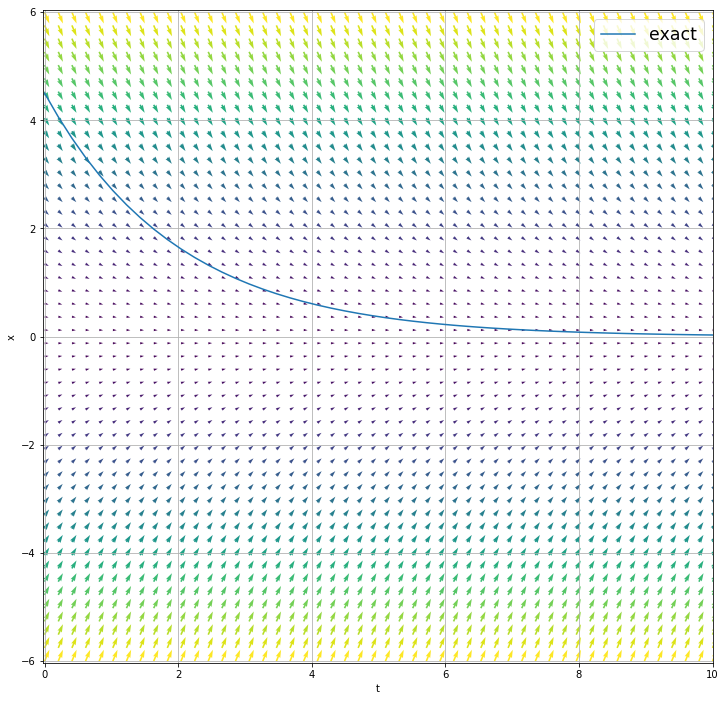

In [7]:
x_0 = 4.5

def exact(t):
    return x_0 * py.exp((-a_1 / a_0) * t)

x_exact_array = exact(t_array)

ode_slope_1state(dx_dt, x_array, t_array)
py.plot(t_array, x_exact_array, label='exact')

py.legend(loc=0, fontsize='xx-large')

py.savefig('slopes_t_x.svg')


$t=0$에서의 $x$의 초기값에 따라 엄밀해가 달라질 수 있음을 기억하자.<br>Let's remember that the exact solution may vary depending on the initial value of $x$ at $t=0$.

이것을 이용해서 미분방정식의 해를 구해볼 수 있을까?<br>Using this, can we find a solution of a differential equation?

## 전진 오일러법<br>Forward Euler Method

$\left(t,x\right) = \left(0, x_0\right)$ 에서의 $x(t)$의 기울기를 생각해 보자.<br>
Let's think about the slope of $x(t)$ at $\left(t,x\right) = \left(0, x_0\right)$.

$$
\left.\frac{d}{dt}x\right|_{\left(t, x\right)=\left(0,x_0\right)}=-\frac{a_1}{a_0} x_0=s_0
$$

그렇다면, $(0, x_0)$점을 지나고 기울기가 $s_0=-\frac{a_1}{a_0} x_0$ 인 직선을 생각할 수 있다.<br>
Then, we can think about a line passing through $(0, x_0)$ with the slope of $s_0=-\frac{a_1}{a_0} x_0$.

$$
x=-\frac{a_1}{a_0} x_0 \left(t -  0 \right) + x_0=s_0\left(t -  0 \right) + x_0
$$

이 직선을 따라 $t_1=t_0 + \Delta t = 0 + 0.5$ 까지 *전진*해 보자.<br>
Following this line, let's move *forward* to $t_1=t_0 + \Delta t = 0 + 0.5$.

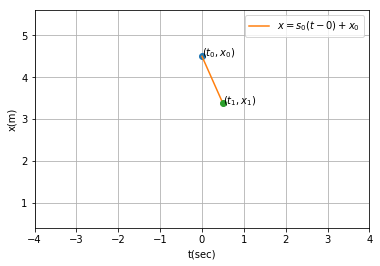

In [8]:
# An initial point
t_0 = 0
x_0 = 4.5
# time step
delta_t = 0.5

# Indicate the initial point
py.plot(t_0, x_0, 'o')
py.text(t_0, x_0, '$(t_0, x_0)$')

# Slope at the initial point
s_0 = dx_dt(x_0, t_0)

# Straight line to next time step
t_0_array = py.linspace(0, delta_t)
x_0_array = s_0 * (t_0_array - t_0) + x_0

# (t_1, x_1) point
t_1, x_1 = t_0_array[-1], x_0_array[-1]

py.plot(t_0_array, x_0_array, label='$x=s_0(t-0)+x_0$')
py.plot(t_1, x_1, 'o')
py.text(t_1, x_1, '$(t_1, x_1)$')

py.axis('equal')

py.xlim(xmin=-4, xmax=4)
py.ylim(ymin=0, ymax=6)

py.xlabel('t(sec)')
py.ylabel('x(m)')

py.legend(loc=0)
py.grid(True)

$(t_1, x_1)$ 에서의 기울기 $s_1$ 과 그러한 기울기를 가지고 $\left(t_1, x_1\right)$ 을 지나는 직선은 다음과 같다.<br>
The slope $s_1$ at $\left(t_1, x_1\right)$ and another line with such slope and passing $\left(t_1, x_1\right)$ would be as follows.

$$
\begin{align}
\left.\frac{d}{dt}x\right|_{\left(t, x\right) = \left(t_1,x_1\right)} &=-\frac{a_1}{a_0} x_1=s_1 \\
x & = s_1\left(t - t_1 \right) + x_1
\end{align}
$$

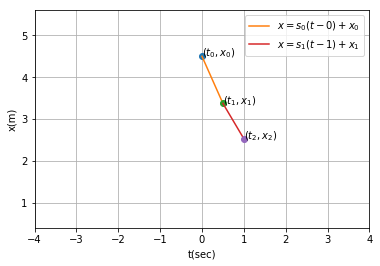

In [9]:
# Indicate the initial point
py.plot(t_0, x_0, 'o')
py.text(t_0, x_0, '$(t_0, x_0)$')

# Indicate the line from (t_0, x_0) with slope s_0
py.plot(t_0_array, x_0_array, label='$x=s_0(t-0)+x_0$')

# Indicate (t_1, x_1) point
py.plot(t_1, x_1, 'o')
py.text(t_1, x_1, '$(t_1, x_1)$')

# Slope at (t_1, x_1) point

s_1 = dx_dt(x_1, t_1)

# Straight line to next time step
t_1_array = py.linspace(t_1, t_1 + delta_t)
x_1_array = s_1 * (t_1_array - t_1) + x_1

# (t_2, x_2) point
t_2, x_2 = t_1_array[-1], x_1_array[-1]

# Indicate the line from (t_1, x_1) with slope s_1
py.plot(t_1_array, x_1_array, label='$x=s_1(t-1)+x_1$')

# Indicate (t_1, x_1) point
py.plot(t_2, x_2, 'o')
py.text(t_2, x_2, '$(t_2, x_2)$')

py.axis('equal')

py.xlim(xmin=-4, xmax=4)
py.ylim(ymin=0, ymax=6)

py.xlabel('t(sec)')
py.ylabel('x(m)')

py.legend(loc=0)
py.grid(True)

엄밀해와 비교해 보자.<br>Let's compare with the exact solution.

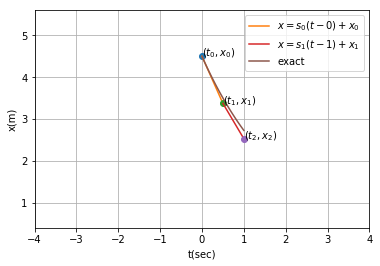

In [10]:
# Indicate the initial point
py.plot(t_0, x_0, 'o')
py.text(t_0, x_0, '$(t_0, x_0)$')

# Indicate the line from (t_0, x_0) with slope s_0
py.plot(t_0_array, x_0_array, label='$x=s_0(t-0)+x_0$')

# Indicate (t_1, x_1) point
py.plot(t_1, x_1, 'o')
py.text(t_1, x_1, '$(t_1, x_1)$')

# Slope at (t_1, x_1) point

s_1 = dx_dt(x_1, t_1)

# Straight line to next time step
t_1_array = py.linspace(t_1, t_1 + delta_t)
x_1_array = s_1 * (t_1_array - t_1) + x_1

# (t_2, x_2) point
t_2, x_2 = t_1_array[-1], x_1_array[-1]

# Indicate the line from (t_1, x_1) with slope s_1
py.plot(t_1_array, x_1_array, label='$x=s_1(t-1)+x_1$')

# Indicate (t_1, x_1) point
py.plot(t_2, x_2, 'o')
py.text(t_2, x_2, '$(t_2, x_2)$')

# Indicate the exact solution
t_array = py.linspace(t_0, t_2)
exact_x_array = exact(t_array)
py.plot(t_array, exact_x_array, label='exact')

py.axis('equal')

py.xlim(xmin=-4, xmax=4)
py.ylim(ymin=0, ymax=6)

py.xlabel('t(sec)')
py.ylabel('x(m)')

py.legend(loc=0)
py.grid(True)

$t$값이 커 짐에 따라, 엄밀해와 $x_1$의 오차 보다 엄밀해와 $x_2$ 사이의 오차가 커지는 것을 볼 수 있다.<br>
As $t$ increases, the error between $x_2$ and the exact solution is larger than the error between $x_1$ and the exact solution.

## 함수로 변환<br>Convert to a function

사용상 편리를 위해 함수를 만들어 보자.<br>To make it easier to use, let's make it a function.

In [11]:
def forward_euler(f, t_array, x_0):
    time_list = [t_array[0]]
    result_list = [x_0]

    x_i = x_0

    for k, t_i in enumerate(t_array[:-1]):
        # time step
        delta_t = t_array[k+1] - t_array[k]

        # slope
        s_i = f(x_i, t_i)

        # x[i + 1]
        x_i_plus_1 = x_i + s_i * delta_t

        time_list.append(t_array[k+1])
        result_list.append(x_i_plus_1)
        
        x_i = x_i_plus_1

    return time_list, result_list


다시 그려 보자.<br>Let's plot again.

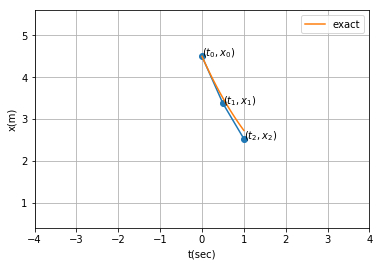

In [12]:
# Time step interval
delta_t = 0.5

# Time array
t_sec_array = np.arange(0, 1 + delta_t*0.5, delta_t)

# Initial state
x_0 = 4.5

# *** new function ***
t, x = forward_euler(dx_dt, t_sec_array, x_0)
# *** new function ***

py.plot(t, x, 'o-')

for k in range(len(t)):
    py.text(t[k], x[k], f'$(t_{k}, x_{k})$')

# Indicate the exact solution
t_array = py.linspace(t_0, t_2)
exact_x_array = exact(t_array)
py.plot(t_array, exact_x_array, label='exact')

py.axis('equal')

py.xlim(xmin=-4, xmax=4)
py.ylim(ymin=0, ymax=6)

py.xlabel('t(sec)')
py.ylabel('x(m)')

py.legend(loc=0)
py.grid(True)

## $\Delta t$ 간격의 영향<br>Influence of $\Delta t$ interval

오차를 줄일 수 있는 좋은 방법이 없을까?<br>Is there a good way to reduce the error?

$\Delta t=0.5$ 를 $\Delta t=0.1$로 한번 줄여 보자.<br>Let's make $\Delta t=0.5$ to $\Delta t=0.1$.

In [13]:
# Time step interval
delta_t = 0.1

# Time array
t_sec_array = np.arange(0, 1 + delta_t*0.5, delta_t)

# Initial state
x_0 = 4.5

# *** new function ***
t_01, x_01 = forward_euler(dx_dt, t_sec_array, x_0)


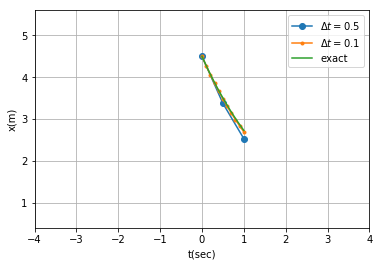

In [14]:
py.plot(t, x, 'o-', label='$\Delta t=0.5$')
py.plot(t_01, x_01, '.-', label='$\Delta t=0.1$')

# Indicate the exact solution
t_array = py.linspace(t_0, t_2)
exact_x_array = exact(t_array)
py.plot(t_array, exact_x_array, label='exact')

py.axis('equal')

py.xlim(xmin=-4, xmax=4)
py.ylim(ymin=0, ymax=6)

py.xlabel('t(sec)')
py.ylabel('x(m)')

py.legend(loc=0)
py.grid(True)

$\Delta t$ 간격을 줄이면 오차에 어떤 영향을 미쳤는가?<br>How did reducing $\Delta t$ interval influence the error?